In [1]:
from sklearn import tree
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

from IPython.display import display
from IPython.display import Image
import pydotplus

In [2]:
from treeThinking import writeTreeYaml

# The Titanic Dataset

Let's quickly walk through the Titanic dataset as an example of a treeThinking usage. 

The Titanic dataset is a famous example of decision trees and random forests, so we'll work with it for familiarity. The data set requires a little cleaning. We follow a similar approach to [this guide](https://blog.socialcops.com/engineering/machine-learning-python/)

In [3]:
titanic_df = pd.read_csv('../titanic.csv', index_col=None, na_values=['NA'])

In [4]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
titanic_df = titanic_df.drop(['body','cabin','boat'], axis=1)
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")

In [6]:
titanic_df = titanic_df.dropna()

In [7]:
from sklearn import preprocessing, cross_validation
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
processed_df = preprocess_titanic_df(titanic_df)
processed_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,2
1,1,1,1,0.9167,1,2,151.5500,2
2,1,0,0,2.0000,1,2,151.5500,2
3,1,0,1,30.0000,1,2,151.5500,2
4,1,0,0,25.0000,1,2,151.5500,2


In [9]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

In [10]:
clf_dt = tree.DecisionTreeClassifier(max_depth=4)
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)

0.75598086124401909

In [11]:
feats = list(processed_df.drop(['survived'], axis=1).columns)

## The Trees

Let's produce our trees in graphical form, and in our nice YAML.

In [12]:
def draw_tree(dat_tree, data_cols, label_cols=['False','True']):
    dot_data = tree.export_graphviz(dat_tree, out_file=None, 
                         feature_names=list(data_cols),  
                         class_names=(label_cols),  
                         filled=True, rounded=True,  
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)  
    display(Image(graph.create_png()))

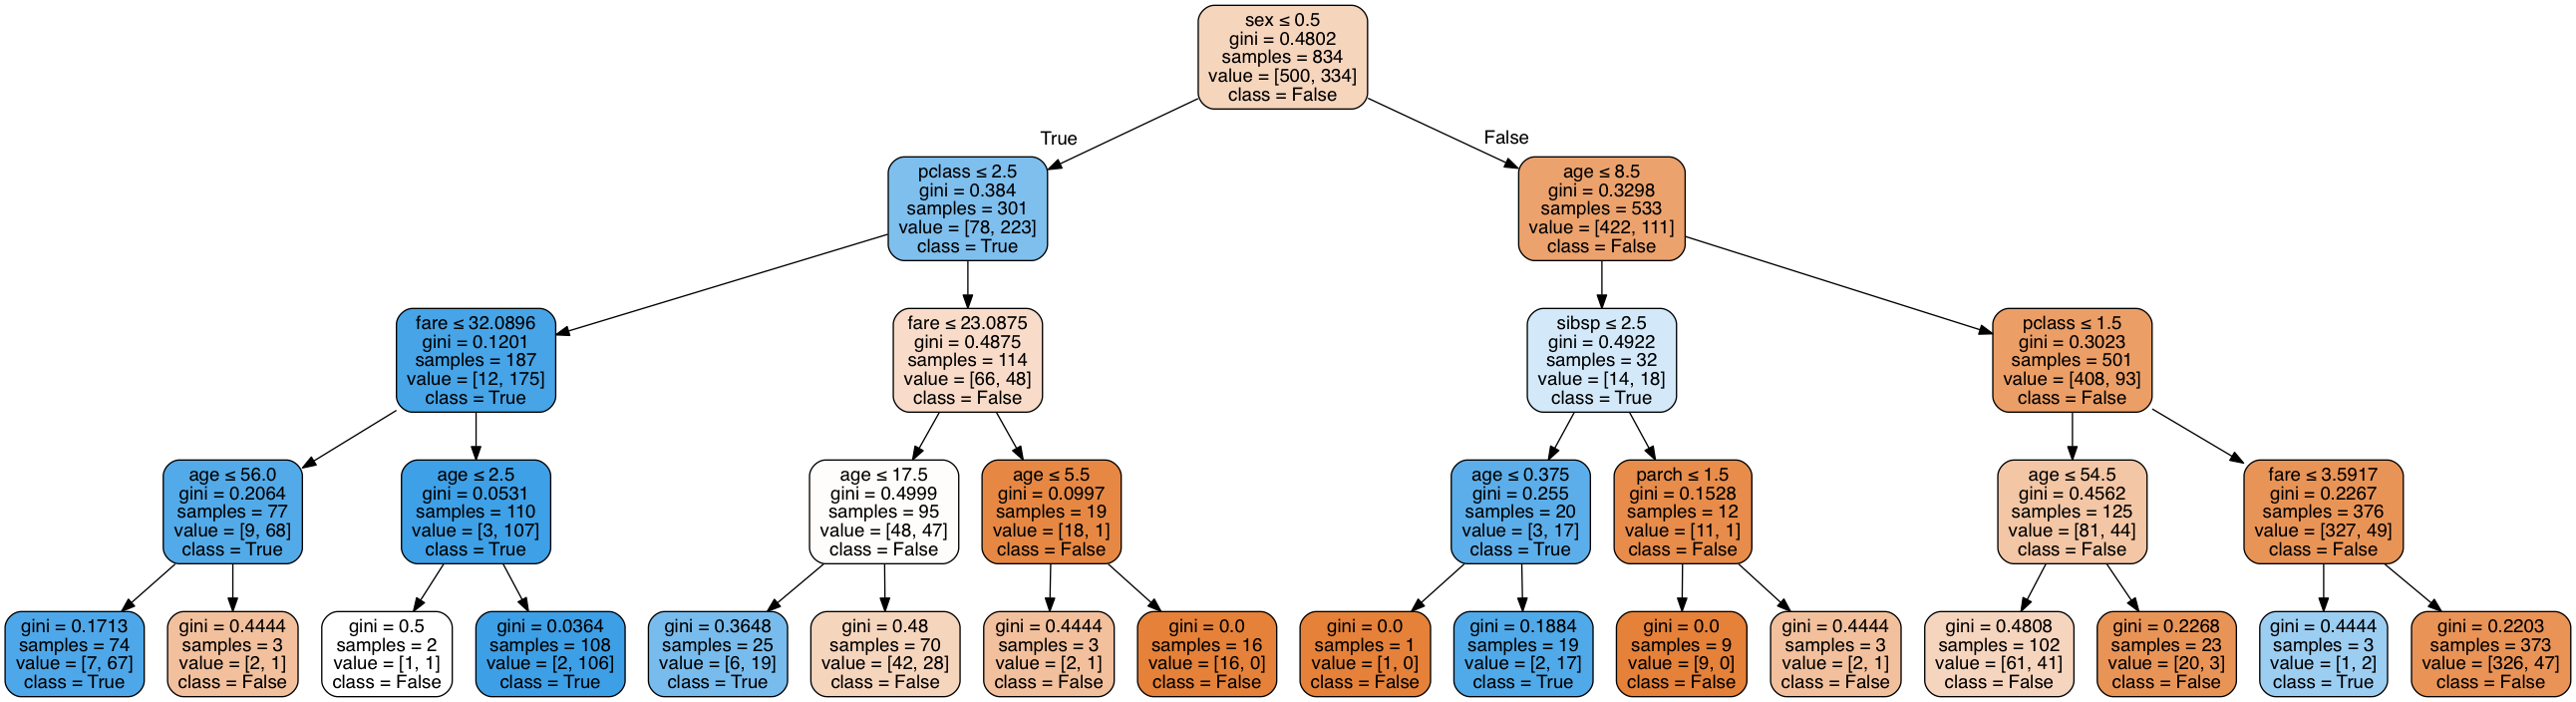

In [13]:
draw_tree(clf_dt, feats)

In [14]:
yaml_tree = writeTreeYaml(clf_dt, feats, 'survived')
print yaml_tree

---
class_name: 'survived'
features:
  - name: 'pclass'
  - name: 'sex'
  - name: 'age'
  - name: 'sibsp'
  - name: 'parch'
  - name: 'fare'
  - name: 'embarked'
nodes:
  feature_idx: 1
  thr: 0.5
  results: 
    true: 
      feature_idx: 0
      thr: 2.5
      results: 
        true: 
          feature_idx: 5
          thr: 32.0895996094
          results: 
            true: 
              feature_idx: 2
              thr: 56.0
              results: 
                true: 
                  prob: 0.905405405405
                false: 
                  prob: 0.333333333333
            false: 
              feature_idx: 2
              thr: 2.5
              results: 
                true: 
                  prob: 0.5
                false: 
                  prob: 0.981481481481
        false: 
          feature_idx: 5
          thr: 23.0874996185
          results: 
            true: 
              feature_idx: 2
              thr: 17.5
              results: 
                true: 

## Parsing and using the YAML

Now, for example we can read in this YAML and parse it.

In [15]:
from treeThinking import yamlSwitch
import yaml

In [16]:
tree_dict = yaml.load(yaml_tree)
predictions = []
for v in X_test:
    predictions.append(yamlSwitch(v, tree_dict['nodes'], tree_dict['class_name'])[1])
# float(sum([(abs(x[0]-x[1])) for x in zip(predictions,y_test)]))/len(predictions)

# The Iris Dataset

The other classical example of decision trees is for the Iris dataset. However, Iris requires multi-label classification("setosa", "virginica", "versicolor").

In [53]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

estimator = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=5, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [57]:
print writeTreeYaml(estimator, iris.feature_names, "label")

---
- class_name: 'label'
  features:
    - 'sepal length (cm)'
    - 'sepal width (cm)'
    - 'petal length (cm)'
    - 'petal width (cm)'
  tree:
    idx: 3
    thr: 0.800000011921
    true_tree: 
      prob: 0.0
    false_tree: 
      idx: 2
      thr: 4.94999980927
      true_tree: 
        idx: 3
        thr: 1.65000009537
      false_tree: 
        prob: 1.0
        true_tree: 
          prob: 1.0
        false_tree: 
          idx: 1
          thr: 3.09999990463
          true_tree: 
            prob: nan
          false_tree: 
            prob: 1.0



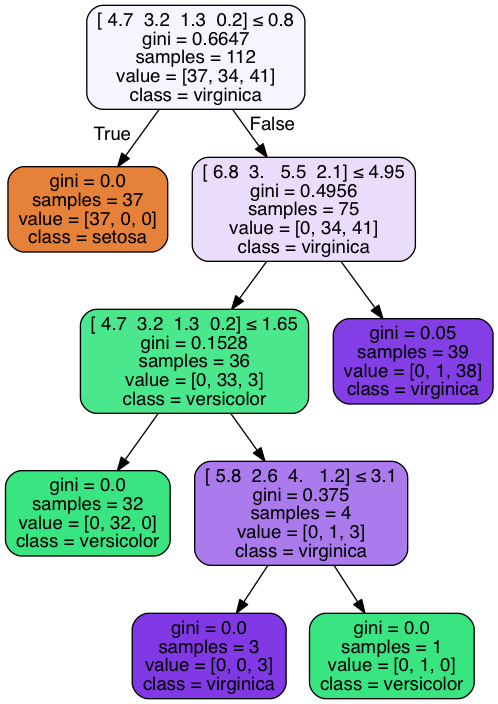

In [72]:
draw_tree(estimator, X_train, iris.target_names)